# Calibration of Black and Scholes, Merton, Kou, Variance Gamma parameters
This notebook aims to find the optimal parameters of **Black-Scholes**, **Merton Jump Diffusion**, **Kou Jump Diffusion** and **Variance Gamma** models. To do so, we compute the european option prices using **closed formulas**, available for all the 4 models, and the **Fast Fourier Transform** for the VG model. Given these theoretical prices, the **implied volatilities** are computed comparing them with real market prices, minimizing their difference. Then we estimate the additional parameters of each model, using the python module `scipy.optimize`.


In [1]:
from functions.MERTONpricer import Merton_pricer
from functions.BSpricer import BS_pricer
from functions.KOUpricer import Kou_pricer
from functions.VGpricer import VG_pricer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import scipy as scp
import scipy.stats as ss
import scipy.optimize as scpo

random.seed(100)

Let's start retrieving historical prices for **european call** and **put** options starting from date **2016-01-20** and expiring **1 year** later. All the data have been collected from [OptionsDX](https://www.optionsdx.com/shop/) and preprocessed in `plainvanilla.py` module. Only options such that
$$ K = S0 \pm 1200 $$ have been selected.

In [2]:
df_call = pd.read_csv('data/options_spx_call_2016.csv')
df_put = pd.read_csv('data/options_spx_put_2016.csv')
print(f'NUM OF CALL OPTS: {df_call.shape[0]}')
print(df_call.head(5))
print(f'NUM OF PUT OPTS: {df_put.shape[0]}')
print(df_put.tail(5))

NUM OF CALL OPTS: 83
   QUOTE_DATE  UNDERLYING_LAST EXPIRE_DATE    C_BID    C_ASK  STRIKE
0  2016-01-20          1859.48  2017-01-20  1119.61  1125.01   700.0
1  2016-01-20          1859.48  2017-01-20  1071.51  1076.80   750.0
2  2016-01-20          1859.48  2017-01-20  1023.00  1028.30   800.0
3  2016-01-20          1859.48  2017-01-20   998.40  1003.60   825.0
4  2016-01-20          1859.48  2017-01-20   974.29   979.51   850.0
NUM OF PUT OPTS: 83
    QUOTE_DATE  UNDERLYING_LAST EXPIRE_DATE    P_BID    P_ASK  STRIKE
78  2016-01-20          1859.48  2017-01-20   958.80   964.10  2800.0
79  2016-01-20          1859.48  2017-01-20  1007.99  1013.29  2850.0
80  2016-01-20          1859.48  2017-01-20  1057.50  1062.90  2900.0
81  2016-01-20          1859.48  2017-01-20  1107.01  1112.50  2950.0
82  2016-01-20          1859.48  2017-01-20  1156.49  1162.01  3000.0


The dataframes **df_calls** and **df_put** contain both 83 options sorted by strike price. For our purpose, using the $25\%$ of these DFs is enough and can lead to very good results. Thus, we sample the rows and then reformulate the dataframes adding **Midpoint** and **Spread** columns.

In [3]:
calls = df_call.sample(frac=0.25, replace=False).sort_index()
puts = df_put.sample(frac=0.25, replace=False).sort_index()

calls['C_Midpoint'] = abs(calls['C_BID'] + calls['C_ASK']) / 2
puts['P_Midpoint'] = abs(puts['P_BID'] + puts['P_ASK']) / 2
calls['C_Spread'] = calls['C_BID'] - calls['C_ASK']
puts['P_Spread'] = puts['P_BID'] - puts['P_ASK']

q = 0           # dividend yield
r = 0.05        # risk-free interest rate
sigma = 0.2     #volatility (variance of diffusion process)
S0 = calls.iloc[0]['UNDERLYING_LAST']
T = 1           # time-to-maturity
call_strikes = calls['STRIKE']    # array of K for call options
put_strikes = puts['STRIKE']      # array of K for put options
exercise = 'european'

call_prices = calls['C_Midpoint']
put_prices = puts['P_Midpoint']

The following code snippet initializes objects of class *BS_pricer*, *Merton_pricer*, *Kou_pricer*, *VG_pricer* with default values as parameters. Then it computes the theoretical call prices using closed formulas of each 4 models, with strike prices given by the *call_strikes* array. Additionally, we use the **Midpoint** price as the option market prices.

In [4]:
BS = BS_pricer(S0=S0, r=r, q = q, sigma=sigma, ttm=T, exercise=exercise, K=None)
Merton = Merton_pricer(S0=S0, K=None, ttm=T, r=0.05, q = q, sigma=0.12, lambd=0.5, meanJ=-0.1, stdJ=0.2, exercise=exercise)
Kou = Kou_pricer(S0=S0, K=None, ttm=T, r=r, sigma=0.12, lambd=0.5, p=0.6, eta1=10, eta2=5, exercise=exercise)
VG = VG_pricer(S0, K=None, ttm=T, r=r, q=q, sigma=0.15, theta=-0.2, nu=0.2, exercise=exercise)

call_th_prices = pd.DataFrame(columns=['Strike','BlackScholes', 'Merton', 'Kou', 'VarianceGamma'])
call_th_prices['Strike'] = call_strikes

for i, K in enumerate(call_strikes):
    bs = BS.closed_formula_call(K)
    mert = Merton.closed_formula_call(K)
    kou = Kou.closed_formula_call(K)
    vg = VG.closed_formula_call(K)
    call_th_prices.iloc[i, 1:] = [bs, mert, kou, vg]

print(f'Theoretical call options prices:')
print(call_th_prices)

Theoretical call options prices:
    Strike BlackScholes       Merton          Kou VarianceGamma
0    700.0  1193.619409  1193.662047  1193.840257   1193.619403
3    825.0  1074.716134  1074.891108  1075.268193   1074.715726
9    975.0   932.047993   932.740028   933.432744    932.031459
10  1000.0   908.278259   909.123672   909.864135    908.250865
14  1100.0   813.291623   815.028771   815.869775    813.131126
17  1175.0   742.285318   745.015489   745.742405    741.803766
21  1275.0   648.409713   652.795804   652.896205    646.792567
24  1350.0   579.182158   584.793841   583.907376    575.793407
27  1425.0   511.673419   518.090618   515.681469    505.463627
29  1475.0   468.008771   474.498455   470.784711    459.356563
30  1500.0   446.672996   453.007313   448.569588    436.674643
37  1675.0   309.475546   310.215128   300.525117    290.574452
39  1725.0   274.989921   272.764557   262.010597    254.660569
40  1750.0   258.637221   254.783093   243.650099    237.883597
43  182

Same for put prices.

In [5]:
put_th_prices = pd.DataFrame(columns=['Strike','BlackScholes', 'Merton', 'Kou', 'VarianceGamma'])
put_th_prices['Strike'] = put_strikes

for i, K in enumerate(put_strikes):
    bs = BS.closed_formula_put(K)
    mert = Merton.closed_formula_put(K)
    kou = Kou.closed_formula_put(K)
    vg = VG.closed_formula_put(K)
    put_th_prices.iloc[i, 1:] = [bs, mert, kou, vg]

print(f'Theoretical put options prices:')
print(put_th_prices)

Theoretical put options prices:
    Strike BlackScholes      Merton         Kou VarianceGamma
0    700.0     0.000006    0.042644    0.220854           0.0
1    750.0     0.000037    0.077622    0.324627           0.0
2    800.0     0.000193    0.135014    0.465343      0.000001
4    850.0     0.000833    0.225735    0.652524      0.000003
7    925.0     0.005556    0.458208    1.045308      0.000036
11  1025.0     0.044749    1.069307    1.851279      0.000558
12  1050.0     0.070572      1.3023    2.116929      0.001049
15  1125.0     0.242293    2.279595     3.10716      0.006186
18  1200.0     0.699559     3.81774    4.448367      0.030726
23  1325.0     3.001581    8.230003    7.729676      0.312778
35  1625.0      32.4843   35.649149   27.332747      15.69148
44  1850.0    99.712742   89.064153    77.62683     79.202353
46  1900.0   121.438635  107.674722   96.815023    102.071386
48  1950.0   145.655528  129.272884  119.397796     127.93541
49  1975.0   158.677458  141.225508  1

### Variance Gamma Fast Fourier Transform
Let's now compare the Closed Forms with the Fast Fourier Transform method for the Variance Gamma model for both call and put options.  The FFT method is explained by Carr, Madan, Chang 1998: *The Variance Gamma Process and Option Pricing*.

In [6]:
c_vg_fft = VG.FFT_call(call_strikes)

for k, a, b in zip(call_strikes, call_th_prices['VarianceGamma'], c_vg_fft):
    print(f'K={k}, CF:{a}, FFT:{b}')

K=700.0, CF:1193.6194028637115, FFT:1193.621720743016
K=825.0, CF:1074.7157262941423, FFT:1074.7327620712704
K=975.0, CF:932.0314585935862, FFT:932.1530276419775
K=1000.0, CF:908.2508654846026, FFT:908.4134863097016
K=1100.0, CF:813.1311255725934, FFT:813.6071542996822
K=1175.0, CF:741.8037660696036, FFT:742.779246483399
K=1275.0, CF:646.7925668537832, FFT:649.0547556780375
K=1350.0, CF:575.7934067767901, FFT:579.6652227133131
K=1425.0, CF:505.4636271748957, FFT:511.50185790186333
K=1475.0, CF:459.35656287404277, FFT:467.0035885222487
K=1500.0, CF:436.67464322706974, FFT:445.10751832962296
K=1675.0, CF:290.5744516808679, FFT:301.0196597538211
K=1725.0, CF:254.6605690291201, FFT:263.720538995354
K=1750.0, CF:237.88359747566778, FFT:245.87259132310305
K=1825.0, CF:192.4339346480873, FFT:195.88807972259565
K=2000.0, CF:113.58980169305914, FFT:102.91071946216755
K=2025.0, CF:105.08515336925382, FFT:92.52314767687085
K=2050.0, CF:97.17623119998291, FFT:82.86322717358189
K=2150.0, CF:70.8409

In [7]:
p_vg_fft = VG.FFT_put(put_strikes)

for k, a, b in zip(put_strikes, put_th_prices['VarianceGamma'], p_vg_fft):
    print(f'K={k}, CF:{a}, FFT:{b}')

K=700.0, CF:1.4211195775715169e-08, FFT:0.0023178935158512104
K=750.0, CF:1.0229211966361618e-07, FFT:0.005390577853745526
K=800.0, CF:6.355965069815284e-07, FFT:0.01177524551735587
K=850.0, CF:3.4655696481422638e-06, FFT:0.024332439226441238
K=925.0, CF:3.5540507610676286e-05, FFT:0.06600698450893105
K=1025.0, CF:0.0005575685053145207, FFT:0.21608633598634697
K=1050.0, CF:0.0010491991865819728, FFT:0.28415458801782734
K=1125.0, CF:0.006186026296063574, FFT:0.615781520762539
K=1200.0, CF:0.03072590810802467, FFT:1.2497052902685937
K=1325.0, CF:0.3127781568887258, FFT:3.5808950313937657
K=1625.0, CF:15.691479579906627, FFT:26.515544896009942
K=1850.0, CF:79.20235279257508, FFT:80.79585538853621
K=1900.0, CF:102.07138624043387, FFT:99.63053937958921
K=1950.0, CF:127.9354099708205, FFT:121.30240895119141
K=1975.0, CF:141.9213667319284, FFT:133.22922539196884
K=2150.0, CF:256.504196377025, FFT:236.9046421013561
K=2450.0, CF:498.2695215271083, FFT:479.5285756304179
K=2500.0, CF:541.85039597

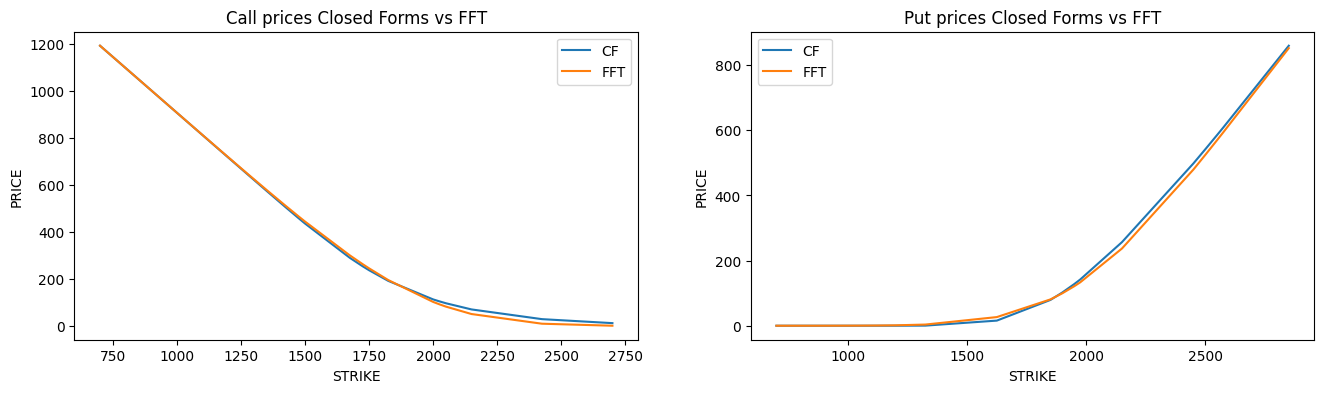

In [8]:
fig = plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(121); ax2 = fig.add_subplot(122)
ax1.plot(call_strikes, call_th_prices['VarianceGamma'], label='CF')
ax1.plot(call_strikes, c_vg_fft, label='FFT')
ax1.set_title('Call prices Closed Forms vs FFT'); ax1.set_xlabel('STRIKE'); ax1.set_ylabel('PRICE')
# ax1.set_xlim([1400,2000]);ax1.set_ylim([0,800])

ax2.plot(put_strikes, put_th_prices['VarianceGamma'], label='CF')
ax2.plot(put_strikes, p_vg_fft, label='FFT')
ax2.set_title('Put prices Closed Forms vs FFT'); ax2.set_xlabel('STRIKE'); ax2.set_ylabel('PRICE')
ax1.legend(); ax2.legend()

## Implied volatility
The function belows implements $3$ methods to compute implied volatility: [Newton](https://en.wikipedia.org/wiki/Newton%27s_method) method, the [Bisection](https://en.wikipedia.org/wiki/Bisection_method) method and a more advanced one, named [Brent](https://en.wikipedia.org/wiki/Brent%27s_method) method. Apart from the initial guess, there is no substantial difference in the final result between **Newton** and **bisection** methods (*fsolve*). The **Implied Volatility** is that value $\sigma$ that must be inserted into the Black-Scholes (BS) formula in order to retrieve the option price quoted in the market:
    $$ BS(S, K, T, r, \sigma) = P,  $$
where $S$ is the underlying spot price, $K$ is the strike, $T$ time to maturity, $r$ risk-free interest rate and $P$ the option price quoted in the market. All these quantities are **observable**.
   

In [9]:
def implied_volatility(price, S, strike, t, rate, q, type_o, method='fsolve', disp=True ):
    """ Returns Implied volatility
        methods:  fsolve (default) or brent
    """

    def obj_fun(vol):
        return BS.BlackScholes(type_o=type_o, S0=S, K=strike, ttm=t, r=rate, q=q, sigma=vol) - price

    def vega(vol):
        return BS.vega(S, strike, rate, q, vol, t)

    if method == 'brent':
        x, res = scpo.brentq(obj_fun, a=1e-15, b=500, full_output=True)
        if res.converged:
            return x

    if method =='fsolve':
        X0 = [0.1, 0.5, 1, 3]        #initial guess points for imp.vol.
        for x_0 in X0:
            x, _, solved, _ = scpo.fsolve(obj_fun, x_0, full_output=True, xtol=1e-8)
            if solved == 1:
                return x[0]

    if method == 'newton':
        guess = 0.5
        result = scpo.newton(obj_fun, guess, vega, tol=1e-4)
        return result


    if disp:
        return -1

Therefore, we can compute the implied volatilities taking into account the theoretical **call prices**..

In [10]:
strikes = call_th_prices['Strike'].tolist(); IV_BS = []; IV_M = []; IV_K = []; IV_VG = []

for i in range(len(call_th_prices)):
    IV_BS.append(implied_volatility(call_th_prices['BlackScholes'].iloc[i], S=S0, strike=strikes[i], t=T, rate=r,q=q, type_o='call', method='newton') )
    IV_M.append(implied_volatility(call_th_prices['Merton'].values[i], S=S0, strike = strikes[i], t=T, rate=r, q=q,  type_o='call', method='newton'))
    IV_K.append(implied_volatility(call_th_prices['Kou'].values[i], S=S0, strike = strikes[i], t=T, rate=r, q=q,  type_o='call', method='newton'))
    IV_VG.append(implied_volatility(call_th_prices['VarianceGamma'].values[i], S=S0, strike=strikes[i], t = T, rate=r, q=q, type_o='call', method='newton'))

imp_vol_call = pd.DataFrame(columns=['Strike', 'BlackScholes', 'Merton', 'Kou', 'VarianceGamma'])
imp_vol_call['Strike'] = strikes
imp_vol_call['BlackScholes'] = IV_BS
imp_vol_call['Merton'] = IV_M
imp_vol_call['Kou'] = IV_K
imp_vol_call['VarianceGamma'] = IV_VG

print(f'Implied volatilities found by each model for call options:\n{imp_vol_call}')

Implied volatilities found by each model for call options:
    Strike  BlackScholes    Merton       Kou  VarianceGamma
0    700.0           0.2  0.310692  0.355674       0.168004
1    825.0           0.2  0.294933  0.330065       0.161270
2    975.0           0.2  0.277462  0.301361       0.154906
3   1000.0           0.2  0.274692  0.296719       0.154028
4   1100.0           0.2  0.263979  0.278406       0.151085
5   1175.0           0.2  0.256232  0.264828       0.149534
6   1275.0           0.2  0.246010  0.246770       0.148502
7   1350.0           0.2  0.238191  0.233221       0.148647
8   1425.0           0.2  0.230072  0.219793       0.149709
9   1475.0           0.2  0.224461  0.211076       0.150967
10  1500.0           0.2  0.221601  0.206847       0.151763
11  1675.0           0.2  0.201456  0.181824       0.159910
12  1725.0           0.2  0.196083  0.176659       0.162766
13  1750.0           0.2  0.193536  0.174440       0.164229
14  1825.0           0.2  0.186602  0.169

... and **put prices**.

In [11]:
strikes = put_th_prices['Strike'].tolist(); IV_BS = []; IV_M = []; IV_K = []; IV_VG = []

for i in range(len(put_prices)):
    IV_BS.append(implied_volatility(put_th_prices['BlackScholes'].values[i], S=S0, strike=strikes[i], t=T, rate=r, q=q, type_o='put', method='newton' ) )
    IV_M.append(implied_volatility(put_th_prices['Merton'].values[i], S=S0, strike = strikes[i], t=T, rate=r, q=q, type_o='put', method='fsolve'))
    IV_K.append(implied_volatility(put_th_prices['Kou'].values[i], S=S0, strike = strikes[i], t=T, rate=r, q=q, type_o='put', method='fsolve'))
    IV_VG.append(implied_volatility(put_th_prices['VarianceGamma'].values[i], S=S0, strike=strikes[i], t = T, rate=r, q=q, type_o='put', method='newton'))

imp_vol_put = pd.DataFrame(columns=['Strike','BlackScholes', 'Merton', 'Kou', 'VarianceGamma'])
imp_vol_put['Strike'] = strikes
imp_vol_put['BlackScholes'] = IV_BS
imp_vol_put['Merton'] = IV_M
imp_vol_put['Kou'] = IV_K
imp_vol_put['VarianceGamma'] = IV_VG

print(f'Implied volatilities found by each model for put options:\n {imp_vol_put}')

Implied volatilities found by each model for put options:
     Strike  BlackScholes    Merton       Kou  VarianceGamma
0    700.0           0.2  0.310692  0.355674       0.168004
1    750.0           0.2  0.304240  0.345192       0.165149
2    800.0           0.2  0.297990  0.335036       0.162510
3    850.0           0.2  0.291918  0.325155       0.160081
4    925.0           0.2  0.283121  0.310748       0.156821
5   1025.0           0.2  0.271961  0.292107       0.153206
6   1050.0           0.2  0.269268  0.287520       0.152440
7   1125.0           0.2  0.261377  0.273871       0.150501
8   1200.0           0.2  0.253678  0.260314       0.149157
9   1325.0           0.2  0.240825  0.237734       0.148502
10  1625.0           0.2  0.207103  0.187949       0.157215
11  1850.0           0.2  0.184553  0.167844       0.170154
12  1900.0           0.2  0.180882  0.165775       0.173090
13  1950.0           0.2  0.177788  0.164409       0.175975
14  1975.0           0.2  0.176456  0.163

In [12]:
print('Total absolute error IV from CALLS vs IV from PUTS: ')
print(f'> BS: ', np.linalg.norm(imp_vol_put['BlackScholes'] - imp_vol_call['BlackScholes'], 1))
print(f'> MERTON: ', np.linalg.norm(imp_vol_put['Merton'] - imp_vol_call['Merton'], 1))
print(f'> KOU: ', np.linalg.norm(imp_vol_put['Kou'] - imp_vol_call['Kou'], 1))
print(f'> VG: ', np.linalg.norm(imp_vol_put['VarianceGamma'] - imp_vol_call['VarianceGamma'], 1))

Total absolute error IV from CALLS vs IV from PUTS: 
> BS:  2.574243725961267e-07
> MERTON:  0.2651533728852656
> KOU:  0.4068386741619859
> VG:  0.16190127181923875


##### Plot

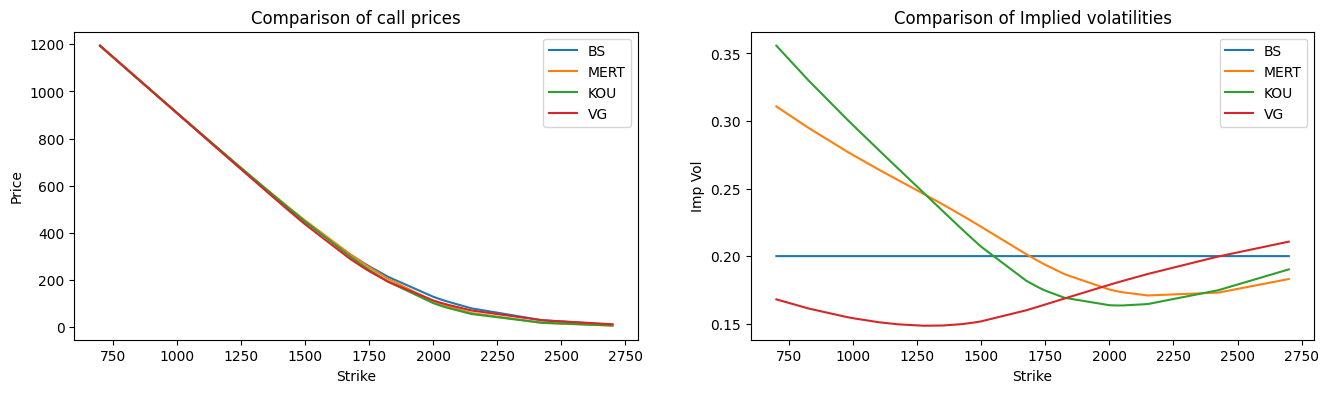

In [13]:
fig = plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(121); ax2 = fig.add_subplot(122)

ax1.plot(call_strikes, call_th_prices['BlackScholes'], label="BS"); ax1.plot(call_strikes, call_th_prices['Merton'], label="MERT")
ax1.plot(call_strikes, call_th_prices['Kou'], label="KOU"); ax1.plot(call_strikes, call_th_prices['VarianceGamma'], label="VG")
ax1.set_title("Comparison of call prices"); ax1.set_xlabel("Strike"); ax1.set_ylabel("Price")

ax2.plot(call_strikes, imp_vol_call['BlackScholes'], label="BS"); ax2.plot(call_strikes, imp_vol_call['Merton'], label="MERT")
ax2.plot(call_strikes, imp_vol_call['Kou'], label="KOU"); ax2.plot(call_strikes, imp_vol_call['VarianceGamma'], label="VG")
ax2.set_title("Comparison of Implied volatilities"); ax2.set_xlabel("Strike"); ax2.set_ylabel("Imp Vol")

ax1.legend(); ax2.legend(); plt.show()

##  Calibration
Let's step now into the calibration of model parameters. We test two functions of `scipy.optimize`:
1. **curve_fit**, a least-squares curve fitting method which works both with and without bounds. When bounds are set it uses the [Trust Region Reflective (trf)](https://en.wikipedia.org/wiki/Trust_region) and the [Levemberg-Marquadt](https://en.wikipedia.org/wiki/Levenberg%E2%80%93Marquardt_algorithm) when they are not.
2. **minimize(method='SLSQP')**, a constrained minimization problem which uses [Sequential Quadratic Programming](https://en.wikipedia.org/wiki/Sequential_quadratic_programming).
First we initialize a starting point in the array $x_0 = [σ, λ, m, v]$, then we set

### Merton Jump Diffusion
The Merton Jump diffusion ones are the volatility $\sigma$, the Poisson rate of jumps $\lambda$, the mean rate of jump intensity $m$ and its variance rate $v$, assuming that the intensity of jumps follows a *Normal distribution*.


In [26]:
x0 = [0.15, 1, 0.1, 1] # initial guess: [σ, λ, m, v]
bounds = ( [0, 1e-2, -10, 0.1], [np.inf, np.inf, 10, 5] )

def f_Mert(x, sigma, lambd, meanJ, stdJ):
    Mert = Merton_pricer(S0=S0, K=x, ttm=T, r=r, q=0, sigma=sigma, lambd=lambd, meanJ=meanJ, stdJ=stdJ, exercise=exercise)
    return Mert.closed_formula_call(x)


##### Method 1. Bounds

In [27]:
res1 = scpo.curve_fit(f_Mert, call_strikes, call_prices, p0=x0, bounds=bounds)

sigt = round(res1[0][0],4)
lambdt = round(res1[0][1],2)
mt = round(res1[0][2],2)
vt = round(res1[0][3],5)

print('METHOD 1: CURVE_FIT (trf)')
print(f'> Calibrated Volatlity [σ] = {sigt} \t {sigt*100}%')
print('> Calibrated Jump intensity [λ] = ', lambdt)
print('> Calibrated Jump Mean = ', mt)
print('> Calibrated Jump St. dev.  = ', vt)

METHOD 1: CURVE_FIT (trf)
> Calibrated Volatlity [σ] = 0.084 	 8.4%
> Calibrated Jump intensity [λ] =  0.28
> Calibrated Jump Mean =  0.11
> Calibrated Jump St. dev.  =  0.1


##### Method 1. No bounds

In [28]:
res1_2 = scpo.curve_fit(f_Mert, call_strikes, call_prices, p0=x0)

sigt2 = round(res1_2[0][0],4)
lambdt2 = round(res1_2[0][1],2)
mt2 = round(res1_2[0][2],2)
vt2 = round(res1_2[0][3],5)

print('METHOD 1.2: CURVE_FIT (Levemberg-Marquadt, no bounds)')
print(f'> Calibrated Volatlity [σ] = {sigt2} \t {sigt2*100}%')
print('> Calibrated Jump intensity [λ] = ', lambdt2)
print('> Calibrated Jump Mean = ', mt2)
print('> Calibrated Jump St. dev.  = ', vt2)

METHOD 1.2: CURVE_FIT (Levemberg-Marquadt, no bounds)
> Calibrated Volatlity [σ] = -0.2283 	 -22.830000000000002%
> Calibrated Jump intensity [λ] =  -0.06
> Calibrated Jump Mean =  -49.69
> Calibrated Jump St. dev.  =  9.84135


##### Method 2. Bounds

In [29]:
x0 = [0.3, 0.8, -0.3, 0.4]      # initial guess: [σ, λ, m, v]
bounds = [(1e-6, 10), (0, 20), (-10, 10),  (0, 15)]

# Define the objective function
def obj_function(x, strikes, prices):
    sigm, lamb, mean, std = x
    Mert = Merton_pricer(S0=S0, K=strikes, ttm=T, r=r, q=0, sigma=sigm, lambd=lamb, meanJ=mean, stdJ=std, exercise=exercise)
    return np.sum((Mert.closed_formula_call(K) - prices) ** 2)

additional_args = (call_strikes, call_prices)

print('> METHOD 2: MINIMIZE (SLSQP)')
res2_1 = scpo.minimize(obj_function, x0, args=additional_args,  method='SLSQP', bounds=bounds, tol=1e-20)
print(res2_1.message)
sigt3, lambdt3, mt3, vt3 = res2_1.x

# Print the results
print('Calibrated Volatility [σ] =', round(sigt3, 5))
print('Calibrated Jump Intensity [λ] =', round(lambdt3, 2))
print('Calibrated Jump Mean [m] =', round(mt3, 2))
print('Calibrated Jump St. dev. [v] =', round(vt3, 2))


print('\n> METHOD 2: MINIMIZE (trust-constr)')
res2_2 = scpo.minimize(obj_function, x0, args=additional_args,  method='trust-constr', bounds=bounds, tol=1e-20)
print(res2_1.message)
sigt4, lambdt4, mt4, vt4 = res2_2.x

# Print the results
print('Calibrated Volatility [σ] =', round(sigt4, 5))
print('Calibrated Jump Intensity [λ] =', round(lambdt4, 2))
print('Calibrated Jump Mean [m] =', round(mt4, 2))
print('Calibrated Jump St. dev. [v] =', round(vt4, 2))

> METHOD 2: MINIMIZE (SLSQP)
Optimization terminated successfully
Calibrated Volatility [σ] = 0.3
Calibrated Jump Intensity [λ] = 0.8
Calibrated Jump Mean [m] = -0.3
Calibrated Jump St. dev. [v] = 0.4

> METHOD 2: MINIMIZE (trust-constr)


c:\users\ornel\appdata\local\programs\python\python38\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


Optimization terminated successfully
Calibrated Volatility [σ] = 0.69033
Calibrated Jump Intensity [λ] = 0.9
Calibrated Jump Mean [m] = -0.36
Calibrated Jump St. dev. [v] = 0.62


In [30]:
mert_params = [sigt, lambdt, mt, vt]

[0.084, 0.28, 0.11, 0.1]


### Kou Jump Diffusion

In [32]:
x0 = [0.1, 0.5, 0.4, 5, 5] # initial guess: [σ, λ, p, η_1, η_2]
bounds = ( [0, 0, 0, 0, 0], [4, 10, 0.9,  10, 10] )

def f_Kou(x, sigma, lambd, p, eta1, eta2):
    KouJD = Kou_pricer(S0=S0, K=x, ttm=T, r=r, sigma=sigma, lambd=lambd, p=p, eta1=eta1, eta2=eta2, exercise=exercise)
    return KouJD.closed_formula_call(x)

##### Method 1. TRF (Bounds)

In [35]:
res1 = scpo.curve_fit(f_Kou, call_strikes, call_prices, p0=x0, bounds=bounds)

sigt = round(res1[0][0],5)
lambdt = round(res1[0][1],2)
pt = round(res1[0][2],2)
eta1_t = round(res1[0][3],1)
eta2_t = round(res1[0][4],1)

print('METHOD 1: CURVE_FIT (trf)')
print(f'> Calibrated Volatlity [σ] = {sigt} \t {sigt*100}%')
print('> Calibrated Jump intensity [λ] = ', lambdt)
print(f'> Calibrated Upward Jump probability [p] = {pt}, [q] = {round(1-pt,2)}')
print('> Calibrated Rate of Exp. 1  [η_1] = ', eta1_t)
print('> Calibrated Rate of Exp. 2  [η_2] = ', eta2_t)

METHOD 1: CURVE_FIT (trf)
> Calibrated Volatlity [σ] = 0.10369 	 10.369%
> Calibrated Jump intensity [λ] =  0.05
> Calibrated Upward Jump probability [p] = 0.9, [q] = 0.1
> Calibrated Rate of Exp. 1  [η_1] =  6.3
> Calibrated Rate of Exp. 2  [η_2] =  10.0


##### Method 2. Bounds

In [40]:
x0 = [0.1, 0.5, 0.5, 8, 4] # initial guess: [σ, λ, p, η_1, η_2]
bounds = [(0, 4), (0, 10), (0, 1),  (1e-6, 10), (1e-6,10)]

# Define the objective function
def obj_function(x, strikes, prices):
    sigm, lamb, p, eta1, eta2 = x
    KouJD = Kou_pricer(S0=S0, K=strikes, ttm=T, r=r, sigma=sigm, lambd=lamb, p=p, eta1=eta1, eta2=eta2, exercise=exercise)
    return np.sum((KouJD.closed_formula_call(K) - prices) ** 2)

additional_args = (call_strikes, call_prices)

res2 = scpo.minimize(obj_function, x0, args=additional_args,  method='SLSQP', bounds=bounds, tol=1e-20)
print('METHOD 2: MINIMIZE (SLSQP)'); print(f'message: {res2.message}\nsuccess:{res2.success}')

sigt2, lambdt2, pt2, eta1_t2, eta2_t2 = res2.x

print(f'> Calibrated Volatlity [σ] = {round(sigt2,4)} \t {round(sigt2*100,2)}%')
print('> Calibrated Jump intensity [λ] = ', round(lambdt2,2))
print(f'> Calibrated Upward Jump probability [p] = {round(pt2,2)}, [q] = {round(1-pt2,2)}')
print('> Calibrated Rate of Exp. 1  [η_1] = ', round(eta1_t2,2))
print('> Calibrated Rate of Exp. 2  [η_2] = ', round(eta2_t2,2))

res3 = scpo.minimize(obj_function, x0, args=additional_args,  method='trust-constr', bounds=bounds, tol=1e-20)
print('METHOD 2: MINIMIZE (trust-constr)'); print(f'message: {res3.message}\nsuccess:{res3.success}')

sigt3, lambdt3, pt3, eta1_t3, eta2_t3 = res3.x

print(f'> Calibrated Volatlity [σ] = {round(sigt3,4)} \t {round(sigt3*100,2)}%')
print('> Calibrated Jump intensity [λ] = ', round(lambdt3,2))
print(f'> Calibrated Upward Jump probability [p] = {round(pt3,2)}, [q] = {round(1-pt3,2)}')
print('> Calibrated Rate of Exp. 1  [η_1] = ', round(eta1_t3,2))
print('> Calibrated Rate of Exp. 2  [η_2] = ', round(eta2_t3,2))

C:\Users\ornel\OneDrive\Desktop\TESI\PythonProjects\Margin-Loans-Pricing\python-modules\functions\KOUpricer.py:121: RuntimeWarning: divide by zero encountered in scalar divide
  self.I(k - 1, a - mu * T, -eta1, -1 / (sigma * np.sqrt(T)), -sigma * eta1 * np.sqrt(T))
C:\Users\ornel\OneDrive\Desktop\TESI\PythonProjects\Margin-Loans-Pricing\python-modules\functions\KOUpricer.py:93: RuntimeWarning: invalid value encountered in scalar multiply
  return -np.exp(alpha * c) / alpha * sum_i - (beta / alpha) ** (n + 1) * (np.sqrt(2 * np.pi) / beta) \
C:\Users\ornel\OneDrive\Desktop\TESI\PythonProjects\Margin-Loans-Pricing\python-modules\functions\KOUpricer.py:124: RuntimeWarning: divide by zero encountered in scalar divide
  self.I(k - 1, a - mu * T, eta2, 1 / (sigma * np.sqrt(T)), -sigma * eta2 * np.sqrt(T))
C:\Users\ornel\OneDrive\Desktop\TESI\PythonProjects\Margin-Loans-Pricing\python-modules\functions\KOUpricer.py:102: RuntimeWarning: invalid value encountered in scalar multiply
  return -np.

METHOD 2: MINIMIZE (SLSQP)
message: Optimization terminated successfully
success:True
> Calibrated Volatlity [σ] = 3.9976 	 399.76%
> Calibrated Jump intensity [λ] =  9.99
> Calibrated Upward Jump probability [p] = 1.0, [q] = 0.0
> Calibrated Rate of Exp. 1  [η_1] =  0.01
> Calibrated Rate of Exp. 2  [η_2] =  0.01


c:\users\ornel\appdata\local\programs\python\python38\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


METHOD 2: MINIMIZE (trust-constr)
message: `xtol` termination condition is satisfied.
success:True
> Calibrated Volatlity [σ] = 0.8464 	 84.64%
> Calibrated Jump intensity [λ] =  0.81
> Calibrated Upward Jump probability [p] = 0.58, [q] = 0.42
> Calibrated Rate of Exp. 1  [η_1] =  7.92
> Calibrated Rate of Exp. 2  [η_2] =  3.99


The following code snippet samples a subset of observations in order to speed up the estimation of parameters in Kou's model.

In [41]:
# Sample of rows of the call dataframe
call_resized = calls.sample(n=6).sort_index()
c_strikes_resized = call_resized['STRIKE']
c_prices_resized = call_resized['C_Midpoint']

x0 = [0.1, 0.5, 0.5, 8, 4] # initial guess: [σ, λ, p, η_1, η_2]

bounds1 = ( [0, 0, 0, 1e-9, 1e-9], [4, 10, 1,  10, 10] )
res1 = scpo.curve_fit(f_Kou, c_strikes_resized, c_prices_resized, p0=x0, bounds=bounds1)
print(res1[0])

bounds2 = [(0, 4), (0, 10), (0, 1),  (1e-9, 20), (1e-9,20)]
additional_args = (c_strikes_resized, c_prices_resized)
res2 = scpo.minimize(obj_function, x0, args=additional_args,  method='SLSQP', bounds=bounds2, tol=1e-20)
print(res2)

(array([7.08053722e-02, 2.50690600e-01, 1.00000000e+00, 1.00000000e+01,
       3.02477179e-04]), array([[ 2.77447894e-01, -3.07789054e+00,  6.72359895e-02,
        -4.12884625e+01,  0.00000000e+00],
       [-3.07789054e+00,  9.31752178e+01, -4.09406708e-01,
         1.57706929e+03,  0.00000000e+00],
       [ 6.72359895e-02, -4.09406708e-01,  3.50628824e-02,
        -4.09504837e+00,  0.00000000e+00],
       [-4.12884625e+01,  1.57706929e+03, -4.09504837e+00,
         2.78937327e+04,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00]]))


C:\Users\ornel\OneDrive\Desktop\TESI\PythonProjects\Margin-Loans-Pricing\python-modules\functions\KOUpricer.py:121: RuntimeWarning: divide by zero encountered in scalar divide
  self.I(k - 1, a - mu * T, -eta1, -1 / (sigma * np.sqrt(T)), -sigma * eta1 * np.sqrt(T))
C:\Users\ornel\OneDrive\Desktop\TESI\PythonProjects\Margin-Loans-Pricing\python-modules\functions\KOUpricer.py:93: RuntimeWarning: invalid value encountered in scalar multiply
  return -np.exp(alpha * c) / alpha * sum_i - (beta / alpha) ** (n + 1) * (np.sqrt(2 * np.pi) / beta) \
C:\Users\ornel\OneDrive\Desktop\TESI\PythonProjects\Margin-Loans-Pricing\python-modules\functions\KOUpricer.py:124: RuntimeWarning: divide by zero encountered in scalar divide
  self.I(k - 1, a - mu * T, eta2, 1 / (sigma * np.sqrt(T)), -sigma * eta2 * np.sqrt(T))
C:\Users\ornel\OneDrive\Desktop\TESI\PythonProjects\Margin-Loans-Pricing\python-modules\functions\KOUpricer.py:102: RuntimeWarning: invalid value encountered in scalar multiply
  return -np.

 message: Inequality constraints incompatible
 success: False
  status: 4
     fun: 0.0
       x: [ 0.000e+00  1.000e+01  1.000e+00  1.704e+01  1.992e+01]
     nit: 3
     jac: [ 8.429e+13 -0.000e+00 -0.000e+00  0.000e+00  0.000e+00]
    nfev: 19
    njev: 3


In [42]:
kou_params = [sigt, lambdt, pt, eta1_t, eta2_t]

### Variance Gamma


In [43]:
x0 = [0.2, -0.05, 0.1]   # initial guess: [σ, θ, v]
bounds = ( [1e-2, -10, 0], [5, 10, 20] )

##### Method 1. Bounds (TRF)

In [54]:
def f_VG(strikes, sigmax, thetax, nux):
    VGamma = VG_pricer(S0=S0, K=None, ttm=T, r=r, q=0, sigma=sigmax, theta=thetax, nu=nux, exercise=exercise)
    vg_prices = []
    for k in strikes:
        vg_prices.append(VGamma.closed_formula_call(k))
    return vg_prices

res1 = scpo.curve_fit(f_VG, call_strikes, call_prices, p0=x0, bounds=bounds)

sigt = round(res1[0][0],5)
thetat = round(res1[0][1],2)
nut = round(res1[0][2],2)

print('METHOD 1: CURVE_FIT (trf)');
print(f'> Calibrated Volatlity [σ] = {sigt}, \t {sigt*100}%')
print('> Calibrated mean rate gamma process [θ] = ', thetat)
print('> Calibrated variance rate gamma process [v]= ', nut)

C:\Users\ornel\OneDrive\Desktop\TESI\PythonProjects\Margin-Loans-Pricing\python-modules\functions\VGpricer.py:50: RuntimeWarning: overflow encountered in exp
  f = lambda u: ss.norm.cdf(a / np.sqrt(u) + b * np.sqrt(u)) * np.exp((g - 1) * np.log(u)) * np.exp(
C:\Users\ornel\OneDrive\Desktop\TESI\PythonProjects\Margin-Loans-Pricing\python-modules\functions\VGpricer.py:50: RuntimeWarning: invalid value encountered in scalar multiply
  f = lambda u: ss.norm.cdf(a / np.sqrt(u) + b * np.sqrt(u)) * np.exp((g - 1) * np.log(u)) * np.exp(
C:\Users\ornel\OneDrive\Desktop\TESI\PythonProjects\Margin-Loans-Pricing\python-modules\functions\VGpricer.py:52: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  result = quad(f, 0, np.inf)
C:\Users\ornel\OneDrive\Desktop\TESI\PythonProjects\Margin-Loans-Pricing\python-modules\functions\VGpricer.py:52: IntegrationWarning: Extremely bad integra

METHOD 1: CURVE_FIT (trf)
> Calibrated Volatlity [σ] = 0.01, 	 1.0%
> Calibrated mean rate gamma process [θ] =  -0.3
> Calibrated variance rate gamma process [v]=  0.14


##### Method 2. Bounds

In [55]:
bounds2 = [(1e-9, 5), (-4, np.inf), (0, np.inf)]

# Define the objective function
def obj_function(x, strikes, prices):
    sigm, theta, nu = x
    VGx = VG_pricer(S0=S0, K=strikes, ttm=T, r=r, q=0, sigma=sigm, theta=theta, nu=nu, exercise=exercise)
    return np.sum((VGx.closed_formula_call(K) - prices) ** 2)

additional_args = (call_strikes, call_prices)

# METHOD SEQUENTIAL LEAST SQUARES
res2 = scpo.minimize(obj_function, x0, args=additional_args,  method='SLSQP', bounds=bounds2, tol=1e-20)
print('METHOD 2: MINIMIZE (SLSQP)'); print(f'message: {res2.message}\nsuccess: {res2.success}')
sigt2, thetat2, nut2 = res2.x

# Print the results
print(f'> Calibrated Volatlity [σ] = {round(sigt2,4)} \t {round(sigt2*100, 2)}%')
print('> Calibrated mean rate gamma process [θ] = ', round(thetat2, 2))
print('> Calibrated variance rate gamma process [v]= ', round(nut2,2))

# METHOD TRUST REGION CONSTRAINED
res3 = scpo.minimize(obj_function, x0, args=additional_args,  method='trust-constr', bounds=bounds2, tol=1e-20)
print('METHOD 2: MINIMIZE (trust-constr)'); print(f'message: {res3.message}\nsuccess: {res3.success}')
sigt3, thetat3, nut3 = res3.x

# Print the results
print(f'> Calibrated Volatlity [σ] = {round(sigt3,4)} \t {round(sigt3*100,2)}%')
print('> Calibrated mean rate gamma process [θ] = ', round(thetat3,2))
print('> Calibrated variance rate gamma process [v]= ', round(nut3,2))

METHOD 2: MINIMIZE (SLSQP)
message: Optimization terminated successfully
success: True
> Calibrated Volatlity [σ] = 0.1998 	 19.98%
> Calibrated mean rate gamma process [θ] =  10.69
> Calibrated variance rate gamma process [v]=  494.69


c:\users\ornel\appdata\local\programs\python\python38\lib\site-packages\scipy\optimize\_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
C:\Users\ornel\OneDrive\Desktop\TESI\PythonProjects\Margin-Loans-Pricing\python-modules\functions\VGpricer.py:67: RuntimeWarning: invalid value encountered in sqrt
  call = self.S0 * Psy(d * np.sqrt((1 - c1) / self.nu), (alpha + s) * np.sqrt(self.nu / (1 - c1)),
C:\Users\ornel\OneDrive\Desktop\TESI\PythonProjects\Margin-Loans-Pricing\python-modules\functions\VGpricer.py:69: RuntimeWarning: invalid value encountered in sqrt
  Psy(d * np.sqrt((1 - c2) / self.nu), alpha * np.sqrt(self.nu / (1 - c2)), self.ttm / self.nu)
c:\users\ornel\appdata\local\programs\python\python38\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is line

METHOD 2: MINIMIZE (trust-constr)
message: `xtol` termination condition is satisfied.
success: True
> Calibrated Volatlity [σ] = 0.7023 	 70.23%
> Calibrated mean rate gamma process [θ] =  -0.22
> Calibrated variance rate gamma process [v]=  0.56


##### Method 1 using FFT prices

In [56]:
def f_VG_fft(strikes, sigmax, thetax, nux):
    VGamma = VG_pricer(S0=S0, K=None, ttm=T, r=r, q=0, sigma=sigmax, theta=thetax, nu=nux, exercise=exercise)
    return VGamma.FFT_call(strikes)

res4 = scpo.curve_fit(f_VG_fft, call_strikes, call_prices, p0=x0, bounds=bounds)

sigt4 = round(res1[0][0],5)
thetat4 = round(res1[0][1],2)
nut4 = round(res1[0][2],2)

print('METHOD 1: CURVE_FIT (trf)')
print(f'> Calibrated Volatlity [σ] = {round(sigt4,4)} \t {round(sigt4*100,2)}%')
print('> Calibrated mean rate gamma process [θ] = ', thetat4)
print('> Calibrated variance rate gamma process [v]= ', nut4)

METHOD 1: CURVE_FIT (trf)
> Calibrated Volatlity [σ] = 0.01 	 1.0%
> Calibrated mean rate gamma process [θ] =  -0.3
> Calibrated variance rate gamma process [v]=  0.14


In [ ]:
vg_params = [sigt, thetat, nut]
print(vg_params)